In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import re

# Sentiment Analysis

## Amazon

In [3]:
reviews = pd.read_csv('./amazon_cells_labelled.txt', sep='\t', header=None)
reviews.columns = ['review', 'score']

In [4]:
reviews.groupby("score").size()

score
0    500
1    500
dtype: int64

*So the classes are perfectly balanced.*

In [6]:
# lets determine which "buzzwords" are more frequent 
word_counts_positive = reviews.query("score == 1").review.str.split(expand=True).stack().value_counts()
word_counts_negative = reviews.query("score == 0").review.str.split(expand=True).stack().value_counts()
# get the words unique to negative review
words_negative = word_counts_negative.index.difference(word_counts_positive.index)
words_positive = word_counts_positive.index.difference(word_counts_negative.index)
x = word_counts_positive[words_positive].sort_values(ascending = False).head(20).index
pos_words = x.to_series().apply(str.lower).values
# also need to pull out the punctuation
y = word_counts_negative[words_negative].sort_values(ascending = False).head(20).index
neg_words = y.to_series().apply(str.lower).values
print("Positive Keywords: \n{}\n\nNegative Keywords:\n{}".format(pos_words, neg_words))

Positive Keywords: 
['great' 'works' 'love' 'best' 'works' 'good' 'nice' 'working' 'nice'
 'pretty' 'excellent' 'good.' 'fine' 'fine.' 'great!' 'data' 'job'
 'sturdy' 'far.' 'phone.']

Negative Keywords:
["don't" 'waste' 'not' 'worst' 'money' 'unit' "didn't" 'bad' 'difficult'
 'what' 'poor' 'poor.' "doesn't" 'return' 'week' 'do' 'broke' 'stay'
 'buying' 'unfortunately']


In [7]:
def percent_capitalized_words(review, return_number = False):
    # first we need to get each sentence
    pattern = re.compile("[A-Z]{2,}")
    words_to_ignore = ["US", "USA", "PC", "AC", "DC", "MP", "PDA",
                    "RAZR", "QWERTY", "BT", "DNA", "HS850", "OS"]
    found = 0  

    sentences = review.split('.')
    num_words = len(sentences)
    for sentence in sentences:
        words = sentence.split(' ') 
        for word in words:
            if word in words_to_ignore:
                continue
            if pattern.match(word):
                found += 1
    if return_number:
        return found
    else:
        return found / num_words

In [4]:
# pos_words = ['great','works','love','best',
#              'good','nice','working','excellent',
#              'good','fine','sturdy']
# neg_words = ["don't","waste","not","worst",
#              "didn't","bad","difficult","poor",
#              "doesn't","return","broke"]

In [8]:
for word in neg_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    reviews[str(word)] = reviews.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
for word in pos_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    reviews[str(word)] = reviews.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )

Let's add a few more.

In [9]:
# I would guess that positive reviews have more exclamation marks than negative ones
1 / (reviews.query("score == 0").review.str.contains("!").sum() / len(reviews))

27.027027027027028

In [10]:
1 / (reviews.query("score == 1").review.str.contains("!").sum() / len(reviews))

12.820512820512821

  * So essentially what this tells us is that 1 in every 12.8 **positive** reviews contain an exclamation mark, while only 1 in every 27 **negative** reviews contain an exclamation mark. Let's add this!
  * 1 in every 3 **positive** reviews is in all caps, while 2 in every 3 **negative** reviews are in all caps - so add this as well!

In [11]:
reviews['exclamation'] = reviews.review.str.contains("!")
# reviews["allcaps"] = reviews.review.str.isupper() too correlated with the below
reviews["percent_capitalized_words"] = reviews.review.apply(percent_capitalized_words)
reviews["num_capitalized_words"] = reviews.review.apply(lambda x: percent_capitalized_words(x, True))

features = list(neg_words) + list(pos_words) + ["exclamation", "percent_capitalized_words", "num_capitalized_words"]
data = reviews[features]
target = reviews['score']

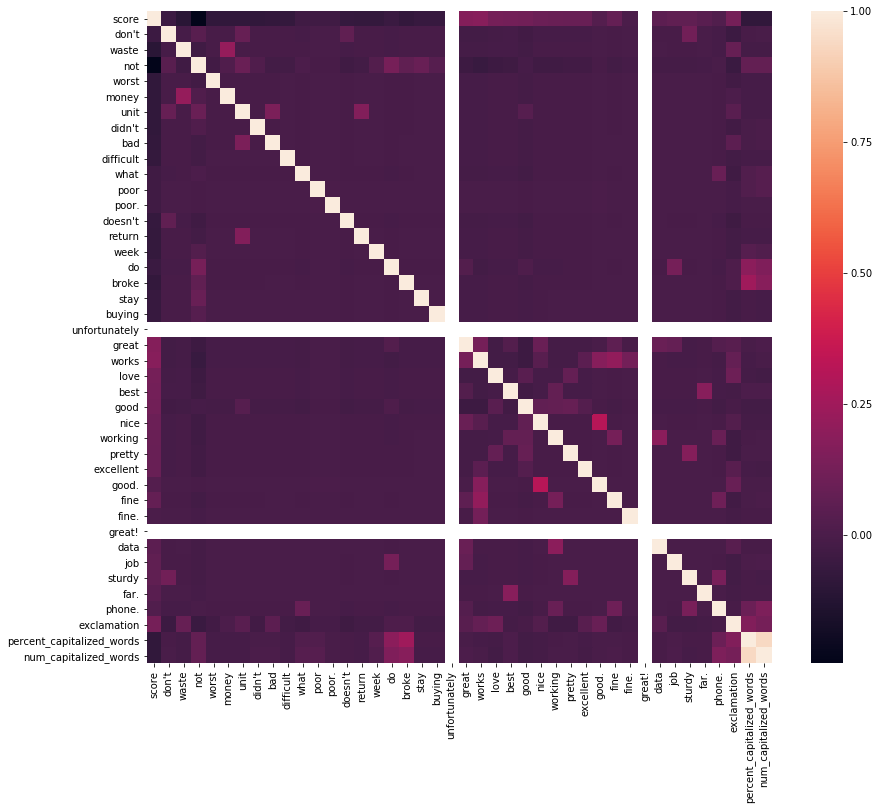

In [12]:
plt.figure(figsize=(14,12))
sns.heatmap(reviews.corr())
plt.show()

  * So our input words appear to be uncorrelated
  
  ### Model

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    random_state=42, test_size=.3)

Train score: 0.66


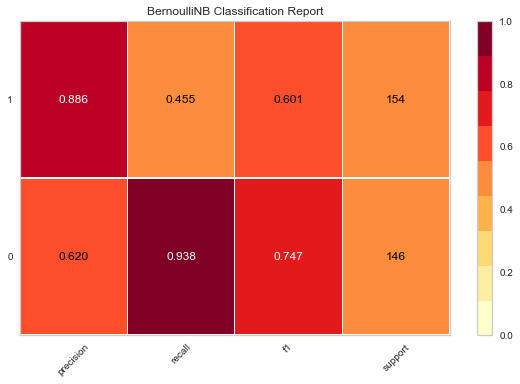

In [59]:
from yellowbrick.classifier import ClassificationReport

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(X_train, y_train)
print('Train score: {:.2f}'.format(bnb.score(X_train, y_train)))

# Instantiate the classification model and visualizer
bayes = BernoulliNB()
visualizer = ClassificationReport(bayes, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

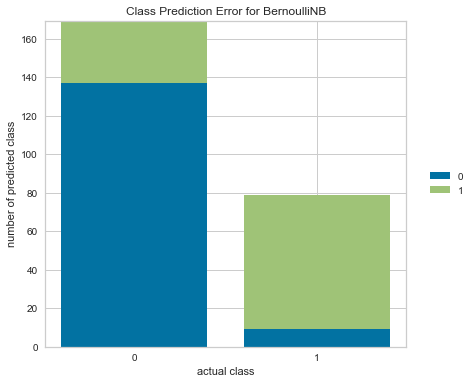

In [60]:
from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    BernoulliNB()
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
g = visualizer.poof()

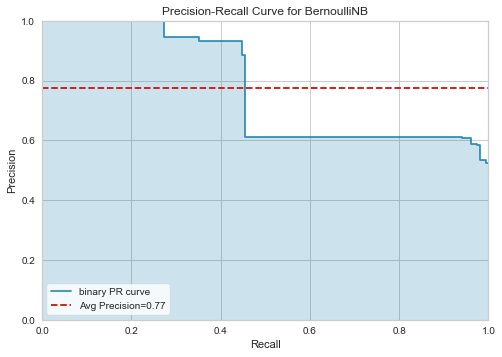

In [61]:
from yellowbrick.classifier import PrecisionRecallCurve

# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(BernoulliNB())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

Here I simply split the original reviews using a 70/30 train/test set split, and then used a simple Naive Bayes Classifier. This model was **66%** accurate, but the precision-recall curve is not very smooth and thus a hard tradeoff must be made. Is predicting negative reviews more important than predicting positive ones?
  
  

# Now we will use the same model on other company reviews

## IMDB

In [45]:
imdb = pd.read_csv('./imdb_labelled.txt', sep='\t', header=None)
imdb.columns = ['review', 'score']
# This is going to use the same features as the model built for Amazon reviews, 
# but on the IMDB data
for word in neg_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    imdb[str(word)] = imdb.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
for word in pos_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    imdb[str(word)] = imdb.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
imdb['exclamation'] = imdb.review.str.contains("!")
# reviews["allcaps"] = reviews.review.str.isupper() too correlated with the below
imdb["percent_capitalized_words"] = imdb.review.apply(percent_capitalized_words)
imdb["num_capitalized_words"] = imdb.review.apply(lambda x: percent_capitalized_words(x, True))
data_imdb = imdb[features]
target_imdb = imdb['score']

In [46]:
X_imdb_train, X_imdb_test, y_imdb_train, y_imdb_test = train_test_split(data_imdb, target_imdb, 
                                                                        test_size=0.3, random_state=42) 

  * So difficult and sturdy do not show up in any IMDB reviews, and there are a few more words that are correlated (which could be an issue for our model, however none of the correlations appear to be greater than 0.5)

Train score: 0.60


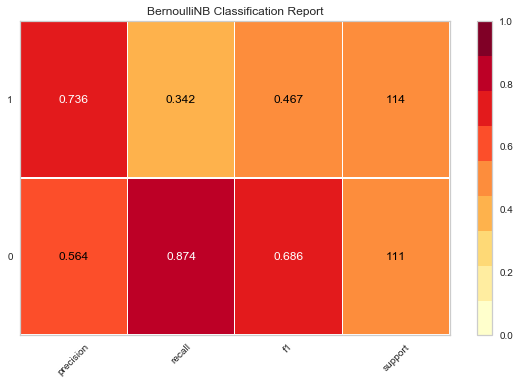

In [57]:
print('Train score: {:.2f}'.format(bnb.score(X_imdb_test, y_imdb_test)))

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(BernoulliNB(), support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_imdb_test, y_imdb_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

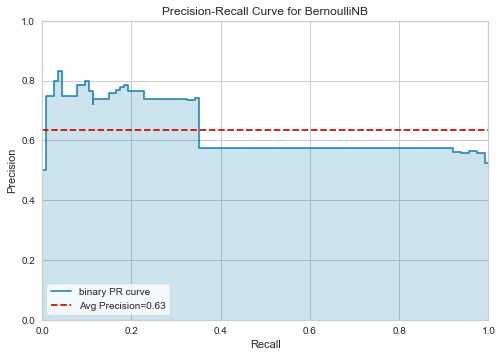

In [62]:
# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(BernoulliNB())
viz.fit(X_train, y_train)
viz.score(X_imdb_test, y_imdb_test)
viz.poof()

We achieve an accuracy of **60%** when using the model trained on Amazon reviews to predict IMDB reviews. Notice that we do not see significant decrease in recall, but this model does suffer when it comes to precision, or how right we are when predicting positive reviews. 

## Yelp

In [52]:
yelp = pd.read_csv('./yelp_labelled.txt', sep='\t', header=None)
yelp.columns = ['review', 'score']
# This is going to use the same features as the model built for Amazon reviews, 
# but on the IMDB data
for word in neg_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    yelp[str(word)] = yelp.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
for word in pos_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    yelp[str(word)] = yelp.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
yelp['exclamation'] = yelp.review.str.contains("!")
# reviews["allcaps"] = reviews.review.str.isupper() too correlated with the below
yelp["percent_capitalized_words"] = yelp.review.apply(percent_capitalized_words)
yelp["num_capitalized_words"] = yelp.review.apply(lambda x: percent_capitalized_words(x, True))
data_yelp = yelp[features]
target_yelp = yelp['score']

  * Yelp reviews do not contain the words difficult, doesn't, broke, working or sturdy
  * otherwise appear to be uncorrelated

Train score: 0.63


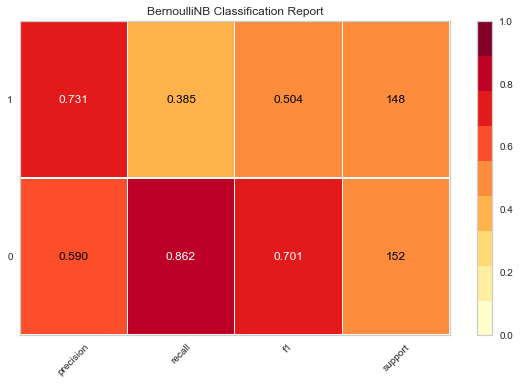

In [55]:
X_yelp_train, X_yelp_test, y_yelp_train, y_yelp_test = train_test_split(data_yelp, target_yelp, 
                                                                        test_size=0.3, random_state=42) 

print('Train score: {:.2f}'.format(bnb.score(X_yelp_test, y_yelp_test)))

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(BernoulliNB(), support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_yelp_test, y_imdb_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data


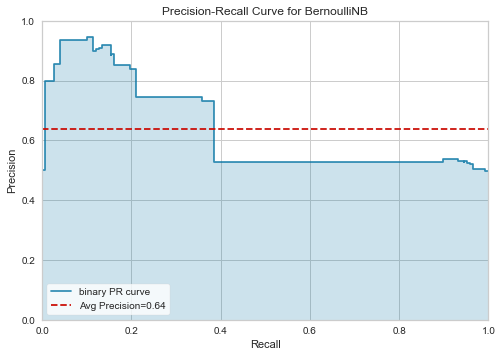

In [63]:
# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(BernoulliNB())
viz.fit(X_train, y_train)
viz.score(X_yelp_test, y_yelp_test)
viz.poof()

This model is **63%** accurate on handling Yelp reviews (trained on Amazon reviews). Here we do see decreased precision and a slight decrease in recall. 


  # Conclusion
  
  We constructed a Naive Bayes classification model by simply using the top frequently used words that were unique to positive and negative reviews, as well as if a review contains an exclamation mark and if the review is all caps (using Amazon reviews). Here were the accuracy rates for each dataset:
    1. Amazon: 66%
    2. IMDB: 60%
    3. Yelp: 63%
    
  As alluded to above, the tradeoff between precision and recall will be critical; if we suspect much larger number of negative reviews we will want to focus on recall, and converting these negative reviews to either neutral (no review) or positive could be much more valuable! More information will be needed in order to make this call.